In [16]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

In [17]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [18]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    SBJ = np.array([])
    Cond = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta = prms['delta'].values[i]
        t0_sp = prms['t0_sp'].values[i]
        t0_ac = prms['t0_ac'].values[i]
        
        if model == 'exp':
            b0_sp = prms['b0_sp'].values[i]
            lamda_sp = prms['lambda_sp'].values[i]
            ub_sp = lambda t: b0_sp * np.exp(-lamda_sp*t)
            
            b0_ac = prms['b0_ac'].values[i]
            lamda_ac = prms['lambda_ac'].values[i]
            ub_ac = lambda t: b0_ac * np.exp(-lamda_ac*t)
        elif model == 'hyp':
            b0_sp = prms['b0_sp'].values[i]
            lamda_sp = prms['lambda_sp'].values[i]
            ub_sp = lambda t: b0_sp / (1 + lamda_sp*t)
            
            b0_ac = prms['b0_ac'].values[i]
            lamda_ac = prms['lambda_ac'].values[i]
            ub_ac = lambda t: b0_ac / (1 + lamda_ac*t)
        elif model == 'ddm':
            b0_sp = prms['b0_sp'].values[i]
            b0_ac = prms['b0_ac'].values[i]
            ub_sp = lambda t: b0_sp
            ub_ac = lambda t: b0_ac
            
        lb_sp = lambda t: -1*ub_sp(t)
        lb_ac = lambda t: -1*ub_ac(t)

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)

        rt = []
        cond = []

        for _ in range(300):
            cond.append('SP')
            rt.append(simulate_CDDM(ub_sp, lb_sp, delta, ndt=t0_sp))
            cond.append('AC')
            rt.append(simulate_CDDM(ub_ac, lb_ac, delta, ndt=t0_ac))

        RT = np.concatenate([RT, rt])
        Cond = np.concatenate([Cond, cond])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'cond':Cond,
                         'rt': np.abs(RT),
                         'accuracy': RT>0}) 

In [19]:
data = pd.read_csv('../../../_Data/Study2.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data['Duration']<data['RT']].reset_index(drop=True)

data['RT']/=1000
data['Duration']/=1000

data_speed = data[data.cue == 'SP'].reset_index(drop=True)
data_accuracy = data[data.cue == 'AC'].reset_index(drop=True)

In [20]:
jhyp = pd.read_csv('_prms/hyp.csv')
jexp = pd.read_csv('_prms/exp.csv')
jddm = pd.read_csv('_prms/jddm.csv')
bhyp = pd.read_csv('_prms/bhyp.csv')
bexp= pd.read_csv('_prms/bexp.csv')
bddm= pd.read_csv('_prms/bddm.csv')

In [6]:
pred_jhyp = get_model_prediction(jhyp, data, 'hyp')

100%|███████████████████████████████████████████| 25/25 [00:20<00:00,  1.21it/s]


In [7]:
pred_bhyp = get_model_prediction(bhyp, data, 'hyp')

100%|███████████████████████████████████████████| 25/25 [00:20<00:00,  1.20it/s]


In [8]:
pred_jexp = get_model_prediction(jexp, data, 'exp')

100%|███████████████████████████████████████████| 25/25 [00:30<00:00,  1.22s/it]


In [9]:
pred_bexp = get_model_prediction(bexp, data, 'exp')

100%|███████████████████████████████████████████| 25/25 [00:33<00:00,  1.34s/it]


In [10]:
pred_jddm = get_model_prediction(jddm, data, 'ddm')

100%|███████████████████████████████████████████| 25/25 [00:16<00:00,  1.56it/s]


In [11]:
pred_bddm = get_model_prediction(bddm, data, 'ddm')

100%|███████████████████████████████████████████| 25/25 [00:13<00:00,  1.86it/s]


In [12]:
def get_rt_acc_corr(pred):
    x = [pred[pred['accuracy']==True]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [pred[(pred['accuracy']==True) & (pred['rt']<x[i])].shape[0]/pred.shape[0] for i in range(len(x))]
    return x, y

def get_rt_acc_incorr(pred):
    x = [pred[pred['accuracy']==False]['rt'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [pred[(pred['accuracy']==False) & (pred['rt']<x[i])].shape[0]/pred.shape[0] for i in range(len(x))]
    return x, y

In [13]:
def plot_data_speed():
    x = [data_speed[data_speed['correct']==1]['RT'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_speed.loc[(data_speed['correct']==1)&(data_speed['RT']<x[i])].shape[0]/data_speed.shape[0] for i in range(len(x))]
    plt.scatter(x, y, c='green', marker='x', label='Data-Correct');
    plt.plot(x, y, c='green', alpha=0.3)

    x = [data_speed[data_speed['correct']==0]['RT'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_speed.loc[(data_speed['correct']==0)&(data_speed['RT']<x[i])].shape[0]/data_speed.shape[0] for i in range(len(x))]
    plt.scatter(x, y, c='red', marker='x', label='Data-Incorrect');
    plt.plot(x, y, c='red', alpha=0.3)
    
def plot_data_accuracy():
    x = [data_accuracy[data_accuracy['correct']==1]['RT'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_accuracy[(data_accuracy['correct']==1)&(data_accuracy['RT']<x[i])].shape[0]/data_accuracy.shape[0] for i in range(len(x))]
    plt.scatter(x, y, c='green', marker='x', label='Data-Correct');
    plt.plot(x, y, c='green', alpha=0.3)

    x = [data_accuracy[data_accuracy['correct']==0]['RT'].quantile(q) for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9]]
    y = [data_accuracy[(data_accuracy['correct']==0)&(data_accuracy['RT']<x[i])].shape[0]/data_accuracy.shape[0] for i in range(len(x))]
    plt.scatter(x, y, c='red', marker='x', label='Data-Incorrect');
    plt.plot(x, y, c='red', alpha=0.3);

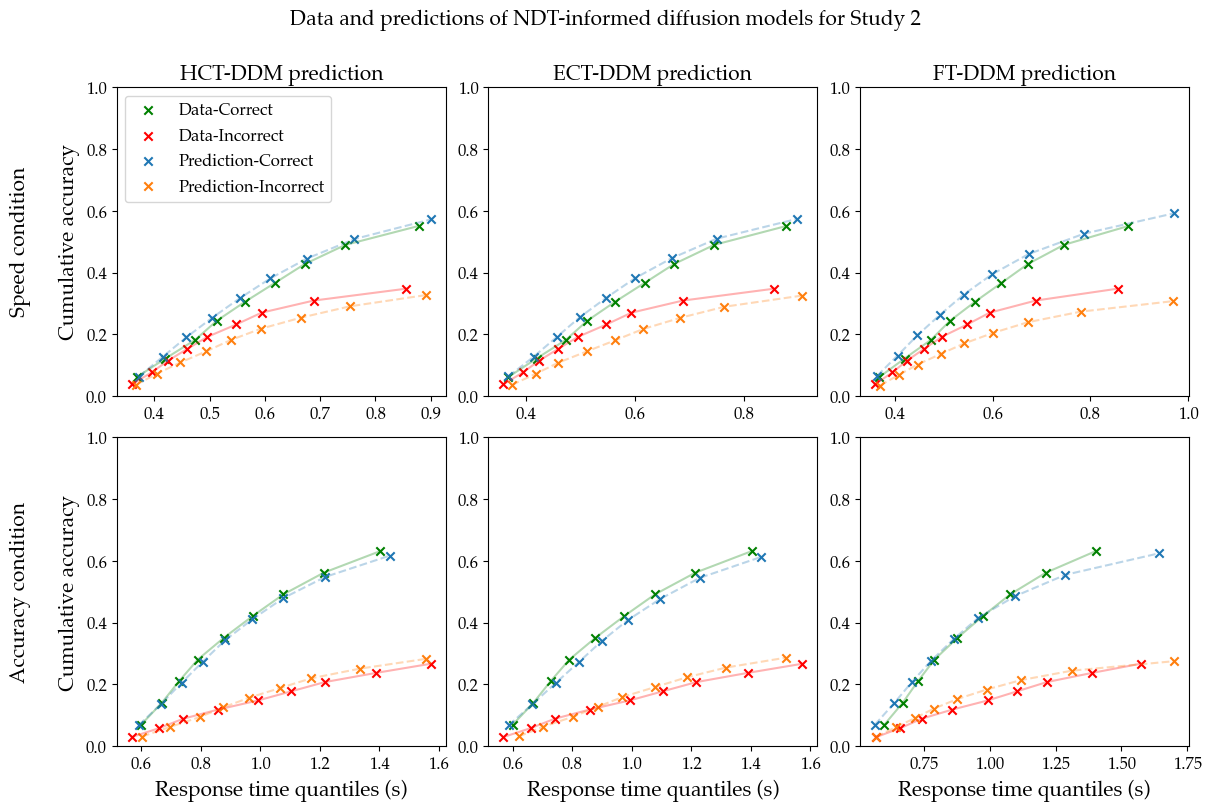

In [15]:
fig = plt.figure(figsize=(12, 8), layout='constrained')
fig.suptitle('Data and predictions of NDT-informed diffusion models for Study 2\n', size=15) # or plt.suptitle('Main title')

plt.subplot(231)
plt.title('HCT-DDM prediction')
plot_data_speed()
x, y = get_rt_acc_corr(pred_jhyp[pred_jhyp['cond']=='SP'])
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_jhyp[pred_jhyp['cond']=='SP'])
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0, 1)
plt.ylabel('Speed condition\n\nCumulative accuracy')
plt.legend(loc='upper left')


plt.subplot(232)
plt.title('ECT-DDM prediction')
plot_data_speed()
x, y = get_rt_acc_corr(pred_jexp[pred_jexp['cond']=='SP'])
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_jexp[pred_jexp['cond']=='SP'])
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0, 1)
# plt.legend(loc='upper left')


plt.subplot(233)
plt.title('FT-DDM prediction')
plot_data_speed()
x, y = get_rt_acc_corr(pred_jddm[pred_jddm['cond']=='SP'])
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_jddm[pred_jddm['cond']=='SP'])
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0, 1)
# plt.legend(loc='upper left')

plt.subplot(234)
plot_data_accuracy()
x, y = get_rt_acc_corr(pred_jhyp[pred_jhyp['cond']=='AC'])
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_jhyp[pred_jhyp['cond']=='AC'])
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0,1)
plt.xlabel('Response time quantiles (s)');
plt.ylabel('Accuracy condition\n\nCumulative accuracy')
# plt.legend(loc='upper left')


plt.subplot(235)
plot_data_accuracy()
x, y = get_rt_acc_corr(pred_jexp[pred_jexp['cond']=='AC'])
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_jexp[pred_jexp['cond']=='AC'])
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0,1)
plt.xlabel('Response time quantiles (s)');
# plt.legend(loc='upper left')


plt.subplot(236)
plot_data_accuracy()
x, y = get_rt_acc_corr(pred_jddm[pred_jddm['cond']=='AC'])
plt.scatter(x, y, marker='x', label='Prediction-Correct');
plt.plot(x, y, linestyle='--', alpha=0.3)
x, y = get_rt_acc_incorr(pred_jddm[pred_jddm['cond']=='AC'])
plt.scatter(x, y, marker='x', label='Prediction-Incorrect');
plt.plot(x, y, linestyle='--', alpha=0.3)
plt.ylim(0,1)
plt.xlabel('Response time quantiles (s)');
# plt.legend(loc='upper left');
plt.savefig('S2_preds_NDT_informed.pdf', 
            transparent=True, 
            dpi=600, 
            bbox_inches='tight');

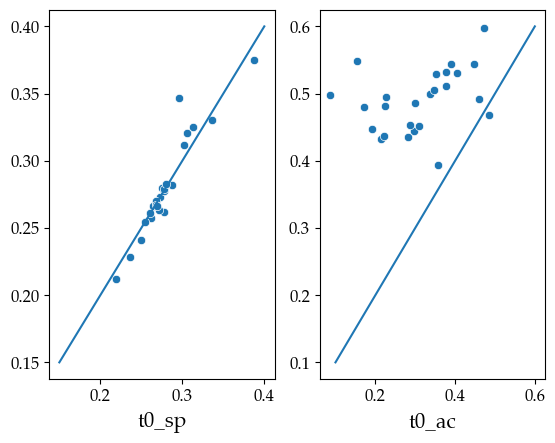

In [32]:
data_speed['Z'] = data_speed['RT'] - data_speed['Duration']
data_accuracy['Z'] = data_accuracy['RT'] - data_accuracy['Duration']
plt.subplot(121)
sns.scatterplot(x=jhyp['t0_sp'], y=data_speed.groupby(by='participant')['Z'].mean().values);
plt.plot(np.linspace(0.15, .4), np.linspace(0.15, .4))

plt.subplot(122)
sns.scatterplot(x=jhyp['t0_ac'], y=data_accuracy.groupby(by='participant')['Z'].mean().values);
plt.plot(np.linspace(0.1, .6), np.linspace(0.1, .6));